# Libraries

In [ ]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading images

In [ ]:
def load_images_and_labels(csv_path):
    data = pd.read_csv(csv_path)

    train_data = data[data['Usage'] == 'Training']
    test_data = data[data['Usage'] == 'PublicTest']

    train_labels = train_data['emotion'].values
    train_pixel_data = train_data['pixels'].values

    test_labels = test_data['emotion'].values
    test_pixel_data = test_data['pixels'].values

    train_images_flat = np.array([np.fromstring(pixels, sep=' ', dtype=np.uint8) for pixels in train_pixel_data])
    total_pixels = train_images_flat.shape[1]
    dim = int(np.sqrt(total_pixels))
    if dim * dim != total_pixels:
        raise ValueError("Pixel data does not form square images.")
    train_images = train_images_flat.reshape((-1, dim, dim, 1))

    # Process public test images
    test_images_flat = np.array([np.fromstring(pixels, sep=' ', dtype=np.uint8) for pixels in test_pixel_data])
    test_images = test_images_flat.reshape((-1, dim, dim, 1))

    return train_images, train_labels, test_images, test_labels, dim

csv_file_path = 'drive/MyDrive/fer2013/fer2013.csv'

train_images, train_labels, test_images, test_labels, inferred_dim = load_images_and_labels(csv_file_path)

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Public test images shape: {test_images.shape}")
print(f"Public test labels shape: {test_labels.shape}")
print(f"Inferred image dimension: {inferred_dim}")

Training images shape: (28709, 48, 48, 1)
Training labels shape: (28709,)
Public test images shape: (3589, 48, 48, 1)
Public test labels shape: (3589,)
Inferred image dimension: 48


# Noise on images

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor.squeeze().detach().cpu().numpy()
    if tensor.ndim == 3:
        tensor = np.transpose(tensor, (1, 2, 0))  # CHW -> HWC
    return tensor

In [ ]:
class SaltAndPepper(torch.nn.Module):
    def __init__(self, noise_ratio):
        super(SaltAndPepper, self).__init__()
        self.noise_ratio = noise_ratio

    def forward(self, x):
        if x.dim() != 3:
            raise ValueError(f"Input must be a 3D tensor [channels, height, width]. Got {x.dim()}D tensor.")

        channels, height, width = x.size()

        num_noise_pixels = int(self.noise_ratio * height * width)

        for _ in range(num_noise_pixels):
            rand_x = torch.randint(0, height, (1,)).item()
            rand_y = torch.randint(0, width, (1,)).item()

            x[:, rand_x, rand_y] = torch.randint(0, 2, (1,)).float()

        return x

# Define U-Net

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256) 

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)  

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)  
    
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1) 
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1) 
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1) 
        dec1 = self.dec1(dec1)

        output = self.output(dec1)
        return output


# Transforming Data

In [ ]:
def plot_images(x, y, num_images=3):
    x = x.permute(0, 2, 3, 1).squeeze().cpu().numpy()
    y = y.permute(0, 2, 3, 1).squeeze().cpu().numpy() 

    fig, axes = plt.subplots(num_images, 2, figsize=(7, 5))
    for i in range(num_images):

        axes[i, 0].imshow(x[i], cmap='gray')
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(y[i], cmap='gray')
        axes[i, 1].set_title(f"Noisy Image {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

Train batch - x shape: torch.Size([64, 1, 48, 48]), y shape: torch.Size([64, 1, 48, 48])


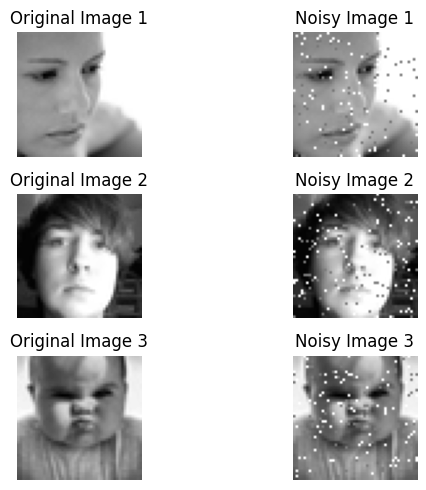

In [ ]:
class NoisyImageDataset(Dataset):
    def __init__(self, images, labels, transform=None, noise_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.noise_transform = noise_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            x = self.transform(image)
        else:
            x = torch.tensor(image, dtype=torch.float32)

        if self.noise_transform:
            y = self.noise_transform(image) 
        else:
            y = x.clone()

        return x, y

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

noise_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    SaltAndPepper(0.07) 
])

train_dataset = NoisyImageDataset(train_images, train_labels, transform=transform, noise_transform=noise_transform)
test_dataset = NoisyImageDataset(test_images, test_labels, transform=transform, noise_transform=noise_transform)

validation_split = 0.2
train_size = int((1 - validation_split) * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
num_workers = 1

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

for x, y in train_loader:
    print(f"Train batch - x shape: {x.shape}, y shape: {y.shape}")
    plot_images(x, y, num_images=3)
    break

In [ ]:
model = UNet()
model

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), st

* Loss function and optimizer

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for org_imgs, noisy_imgs in train_loader:
    print(f"Original Images Shape: {org_imgs.shape}")
    print(f"Noisy Images Shape: {noisy_imgs.shape}")
    break

Original Images Shape: torch.Size([64, 1, 48, 48])
Noisy Images Shape: torch.Size([64, 1, 48, 48])


* Training Process

In [ ]:
plt.ion()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
valid_loss_min = np.Inf

history = {'train': [], 'valid': []}

for epoch in range(epochs):
    print(f'Epoch {epoch + 1} ...')

    model.train()
    sum_train_mse = 0
    training_steps = 0
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y = batch
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(y)
        loss = criterion(output, x)

        loss.backward()
        optimizer.step()

        sum_train_mse += loss.cpu().item()
        training_steps += 1

    model.eval()
    sum_valid_mse = 0
    valid_steps = 0
    for batch in tqdm(validation_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(y)
        loss = criterion(output, x)

        sum_valid_mse += loss.cpu().item()
        valid_steps += 1

    avg_train_mse = sum_train_mse / training_steps
    avg_valid_mse = sum_valid_mse / valid_steps

    if avg_valid_mse < valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {avg_valid_mse:.6f}). The new model is saved.')
        torch.save(model.state_dict(), 'UNet_best_model.pt')
        valid_loss_min = avg_valid_mse

    # Update the history dictionary
    history['train'].append(avg_train_mse)
    history['valid'].append(avg_valid_mse)

    # Print loss summary
    print(f'Epoch {epoch + 1}, Average Train MSE: {avg_train_mse:.6f}, Average Validation MSE: {avg_valid_mse:.6f}')


Epoch 1 ...


100%|██████████| 90/90 [00:31<00:00,  2.86it/s]


Validation loss decreased (inf --> 0.005414). The new model is saved.
Epoch 1, Average Train MSE: 0.009825, Average Validation MSE: 0.005414
Epoch 2 ...


100%|██████████| 90/90 [00:29<00:00,  3.07it/s]


Validation loss decreased (0.005414 --> 0.004284). The new model is saved.
Epoch 2, Average Train MSE: 0.006009, Average Validation MSE: 0.004284
Epoch 3 ...


100%|██████████| 90/90 [00:30<00:00,  2.97it/s]


Validation loss decreased (0.004284 --> 0.003329). The new model is saved.
Epoch 3, Average Train MSE: 0.004841, Average Validation MSE: 0.003329
Epoch 4 ...


100%|██████████| 90/90 [00:30<00:00,  2.94it/s]


Validation loss decreased (0.003329 --> 0.002434). The new model is saved.
Epoch 4, Average Train MSE: 0.003959, Average Validation MSE: 0.002434
Epoch 5 ...


100%|██████████| 90/90 [00:30<00:00,  2.98it/s]


Validation loss decreased (0.002434 --> 0.002013). The new model is saved.
Epoch 5, Average Train MSE: 0.003633, Average Validation MSE: 0.002013
Epoch 6 ...


100%|██████████| 90/90 [00:30<00:00,  2.98it/s]


Epoch 6, Average Train MSE: 0.003619, Average Validation MSE: 0.003184
Epoch 7 ...


100%|██████████| 90/90 [00:30<00:00,  2.98it/s]


Validation loss decreased (0.002013 --> 0.001764). The new model is saved.
Epoch 7, Average Train MSE: 0.003185, Average Validation MSE: 0.001764
Epoch 8 ...


100%|██████████| 90/90 [00:30<00:00,  2.96it/s]


Epoch 8, Average Train MSE: 0.003133, Average Validation MSE: 0.001852
Epoch 9 ...


100%|██████████| 90/90 [00:29<00:00,  3.01it/s]


Validation loss decreased (0.001764 --> 0.001635). The new model is saved.
Epoch 9, Average Train MSE: 0.003037, Average Validation MSE: 0.001635
Epoch 10 ...


100%|██████████| 90/90 [00:30<00:00,  2.92it/s]


Validation loss decreased (0.001635 --> 0.001555). The new model is saved.
Epoch 10, Average Train MSE: 0.002894, Average Validation MSE: 0.001555


* Trend of Training

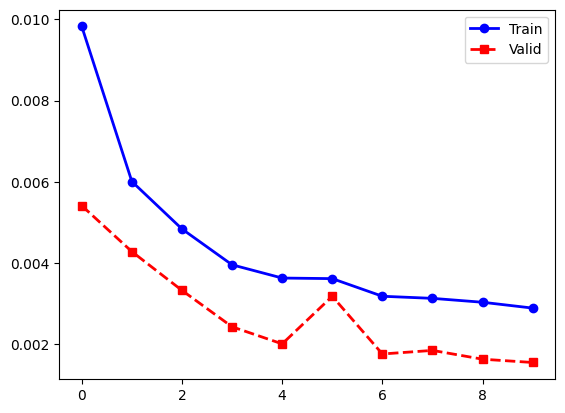

In [ ]:
plt.plot(
    history['train'],
    marker='o',  
    linestyle='-',
    color='blue', 
    linewidth=2, 
    label='Train'
)

plt.plot(
    history['valid'],
    marker='s',  
    linestyle='--', 
    color='red',
    linewidth=2, 
    label='Valid'
)

plt.legend()

* Test Process

In [ ]:
model.eval()

all_original_images = []
all_noisy_images = []
all_denoised_images = []

with torch.no_grad():
    for org_imgs, noise_imgs in test_loader:
        noise_imgs = noise_imgs.to(device)

        denoised_imgs = model(noise_imgs).cpu()

        all_original_images.append(org_imgs)
        all_noisy_images.append(noise_imgs.cpu())
        all_denoised_images.append(denoised_imgs)

all_original_images = torch.cat(all_original_images, dim=0)
all_noisy_images = torch.cat(all_noisy_images, dim=0)
all_denoised_images = torch.cat(all_denoised_images, dim=0)

print(f"Test completed. Original images: {all_original_images.shape}, Noisy images: {all_noisy_images.shape}, Denoised images: {all_denoised_images.shape}")

Test completed. Original images: torch.Size([3589, 1, 48, 48]), Noisy images: torch.Size([3589, 1, 48, 48]), Denoised images: torch.Size([3589, 1, 48, 48])


In [ ]:
mse = torch.mean((all_original_images - all_denoised_images) ** 2).item()
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.0015600700862705708


In [ ]:
def psnr(original, denoised, max_pixel_value=1.0):
    mse = torch.mean((original - denoised) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * torch.log10(max_pixel_value / torch.sqrt(mse))

psnr_value = psnr(all_original_images, all_denoised_images)
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.2f} dB")

Peak Signal-to-Noise Ratio (PSNR): 28.07 dB


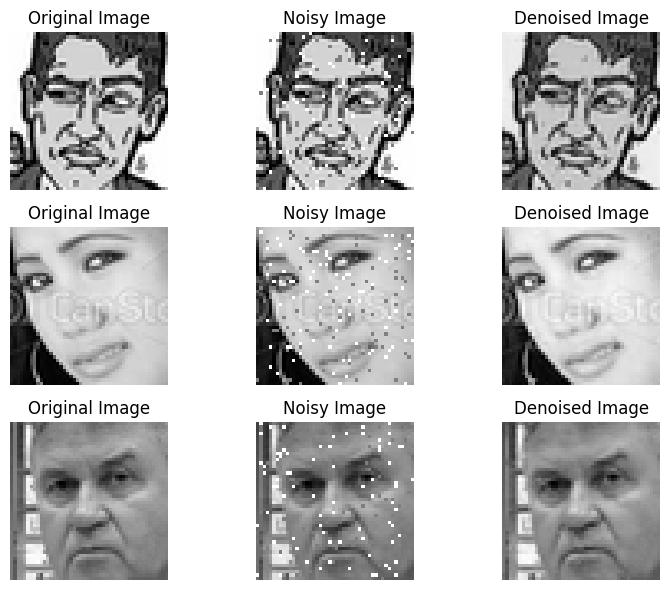

In [ ]:
def visualize_images(original, noisy, denoised, num_images=3):
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 2 * num_images))
    for i in range(num_images):
        # Original Image
        axes[i, 0].imshow(original[i].permute(1, 2, 0).squeeze(), cmap="gray")
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Noisy Image
        axes[i, 1].imshow(noisy[i].permute(1, 2, 0).squeeze(), cmap="gray")
        axes[i, 1].set_title("Noisy Image")
        axes[i, 1].axis("off")

        # Denoised Image
        axes[i, 2].imshow(denoised[i].permute(1, 2, 0).squeeze(), cmap="gray")
        axes[i, 2].set_title("Denoised Image")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_images(all_original_images, all_noisy_images, all_denoised_images, num_images=3)